## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import sys
import json

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

# custom helper functions
from utils import *

RANDOM_SEED = 0

2022-05-01 21:34:52.374195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 21:34:52.374238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data & Develop Test/Train Splits

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan.json"
MULTIMODAL_PATH = "/storage/graham/music/fma_small_echonest.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, mfcc, features, y = load_multimodal_data(MULTIMODAL_PATH)

CPU times: user 29.7 s, sys: 5.03 s, total: 34.7 s
Wall time: 37.6 s


## Multi-Modal Model

### First: Prepare Dataset

In [4]:
TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.3

# create train/test/val splits
x_train, x_val, x_test, y_train, y_val, y_test = test_train_val_split(features, 
                                                                      y, 
                                                                      test_size=TEST_SPLIT, 
                                                                      val_size=VALIDATION_SPLIT, 
                                                                      rseed=RANDOM_SEED)

mfcc_train, mfcc_val, mfcc_test, _, _, _ = test_train_val_split(mfcc, 
                                                                  y, 
                                                                  test_size=TEST_SPLIT, 
                                                                  val_size=VALIDATION_SPLIT, 
                                                                  rseed=RANDOM_SEED)

# reshape MFCC to be a vector
mfcc_train_vec = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1]*mfcc_train.shape[2])
mfcc_test_vec = mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1]*mfcc_test.shape[2])

# add an axis to input sets
mfcc_train = mfcc_train[..., np.newaxis]
mfcc_val = mfcc_val[..., np.newaxis]

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], 1)
mlp_input_shape = x_train.shape[1]

### Second: Build and Train Model

In [5]:
mlp = build_multimodal_mlp(mlp_input_shape)
cnn = build_multimodal_cnn(cnn_input_shape)

x = keras.layers.Concatenate()([mlp.output, cnn.output])

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Dense(len(genres), activation="softmax")(x)

model = keras.Model(inputs=[mlp.input, cnn.input], outputs=x)

OPTIMIZER = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=OPTIMIZER)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 259, 13, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 257, 11, 32)  320         ['conv2d_input[0][0]']           
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 129, 6, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 129, 6, 32)  128         ['max_pooling2d[0][0]']      

2022-05-01 21:35:33.998265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 21:35:33.998305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 21:35:33.998397: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-01 21:35:33.999235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
186/188 [============================>.] - ETA: 0s - loss: 2.2113 - accuracy: 0.2456
Epoch 1: val_loss improved from inf to 2.10294, saving model to /storage/graham/music/models//multimodal/


2022-05-01 21:35:40.603868: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


188/188 [==============================] - 7s 33ms/step - loss: 2.2096 - accuracy: 0.2464 - val_loss: 2.1029 - val_accuracy: 0.3524 - lr: 0.0010
Epoch 2/30
187/188 [============================>.] - ETA: 0s - loss: 1.8329 - accuracy: 0.3573
Epoch 2: val_loss improved from 2.10294 to 1.58823, saving model to /storage/graham/music/models//multimodal/
188/188 [==============================] - 7s 36ms/step - loss: 1.8322 - accuracy: 0.3576 - val_loss: 1.5882 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 3/30
187/188 [============================>.] - ETA: 0s - loss: 1.7142 - accuracy: 0.3930
Epoch 3: val_loss did not improve from 1.58823
188/188 [==============================] - 5s 25ms/step - loss: 1.7144 - accuracy: 0.3930 - val_loss: 1.6944 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 4/30
185/188 [============================>.] - ETA: 0s - loss: 1.6512 - accuracy: 0.4164
Epoch 4: val_loss did not improve from 1.58823
188/188 [==============================] - 5s 24ms/step - loss: 1.6525 - 

Epoch 28/30
188/188 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.6811
Epoch 28: val_loss did not improve from 1.16975
188/188 [==============================] - 5s 26ms/step - loss: 1.0173 - accuracy: 0.6811 - val_loss: 1.3422 - val_accuracy: 0.5678 - lr: 0.0010
Epoch 29/30
187/188 [============================>.] - ETA: 0s - loss: 0.9607 - accuracy: 0.7077
Epoch 29: val_loss did not improve from 1.16975
188/188 [==============================] - 5s 27ms/step - loss: 0.9616 - accuracy: 0.7077 - val_loss: 1.2164 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 30/30
187/188 [============================>.] - ETA: 0s - loss: 0.9605 - accuracy: 0.7035
Epoch 30: val_loss did not improve from 1.16975
188/188 [==============================] - 5s 27ms/step - loss: 0.9600 - accuracy: 0.7038 - val_loss: 1.2493 - val_accuracy: 0.5833 - lr: 0.0010


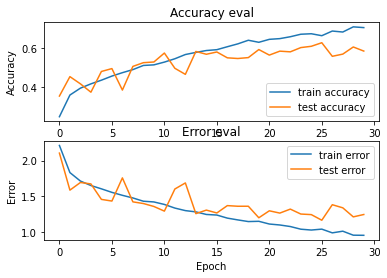

115/115 - 1s - loss: 1.2248 - accuracy: 0.5805 - 923ms/epoch - 8ms/step

Test accuracy: 0.5805396437644958


In [6]:
# get callbacks
MODEL_SAVE_PATH = MODEL_PATH + "/multimodal/"
saveBest, es, lr = setup_callbacks(model, MODEL_SAVE_PATH)

# train model
history = model.fit([x_train, mfcc_train], y_train, 
                    validation_data=([x_val, mfcc_val], y_val), 
                    batch_size=32,
                    epochs=30,
                    callbacks = [saveBest, es, lr])

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate([x_test, mfcc_test], y_test, verbose=2)
print('\nTest accuracy:', test_acc)